In [1]:
import numpy as np
from gurobipy import *
from scipy.stats import beta
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import time

In [2]:
M = 2
#supply

N = 8
#demand

T = 4
#period

num_i = M
num_j = N
num_t = T

bar_I = np.array([1 for i in range(num_i)])
# I_binary,initial solution for benders

Z = np.array([(250*num_j)/num_i for i in range(num_i)])
# Z'i_capacity

demand = 200+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_t*num_j, 0.01), 2, 4)
zeta=demand.reshape(num_t,num_j)
for t in range(num_t):
    for j in range(num_j):
        zeta[t,j]=round(zeta[t,j],0)
#zeta=np.array([[0 for j in range(num_j)]for t in range(num_t)])
#demand1 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#demand2 = 400+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#demand3 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#demand4 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#for j in range(num_j):
#    zeta[0,j]=round(demand1[j],2)
#    zeta[1,j]=round(demand2[j],2)
#    zeta[2,j]=round(demand3[j],2)
#    zeta[3,j]=round(demand4[j],2)

zetau=zeta
#U'tj 需求均值

zetaup=1.1*zetau
#zetau'jt 需求上界

zetalow=0.9*zetau
#zetal'jt 需求下界

eta = 50
# eta_price

c =np.array([30 for i in range(num_i)])
# ci_productioncost

C =np.array([10 for j in range(num_j)])
# Cj_inventory cost

d= np.array([
[3,6,6,7,7,3,8,8],
[6,5,5,6,3,3,8,5]])
# dij_transportationcost

F= np.array([20 for i in range(num_i)])
#Fi_fixed construction cost

f=np.array([[0.8
    for j in range(num_j)]
    for t in range(num_t)])
#ftj_target of fill rate


#R=16328.445
R=40390.68
#R=94949
#target profit

num_k = 3
a = [0.3909, 0.01298,0]
b = [0, 0.8701, 1]
#piecewise linear function,k=3

epsilon=0.01


params = dict()
params["num_i"] = num_i
params["num_j"] = num_j
params["num_t"] = num_t
params["Z"] = Z
#params["P"] = P
params["zetau"] = zetau
params["zetaup"] = zetaup
params["zetalow"] = zetalow
params["eta"] = eta
params["c"] = c
params["C"] = C
params["d"] = d
params["F"] = F
params["f"] = f
params["R"] = R
params["a"] = a
params["b"] = b
params["epsilon"] = epsilon
params["bar_I"] = bar_I

In [3]:
mip = Model()
#决策变量
q0 = mip.addVars([t for t in range(num_t)],
                 [i for i in range(num_i)], 
                 [j for j in range(num_j)],
                 lb=-1*GRB.INFINITY,
                 vtype=GRB.CONTINUOUS, name="q0")
q = mip.addVars([t for t in range(num_t)],
                [tt for tt in range(num_t)],
                [i for i in range(num_i)], 
                [j for j in range(num_j)],
                lb=-1*GRB.INFINITY,
                vtype=GRB.CONTINUOUS, name="q")
P = mip.addVars([t for t in range(num_t)],
                [i for i in range(num_i)],
                vtype=GRB.CONTINUOUS, name="P")
I = mip.addVars([i for i in range(num_i)],
                vtype=GRB.BINARY, name="I")
alpha=mip.addVars([t for t in range(num_t)],
                  [j for j in range(num_j)],
                  vtype=GRB.CONTINUOUS, name="alpha")

#####################################################
S0= mip.addVars([t for t in range(num_t)],
                [j for j in range(num_j)],
                lb=-1*GRB.INFINITY,
                vtype=GRB.CONTINUOUS, name="S0")
S= mip.addVars([t for t in range(num_t)],
               [j for j in range(num_j)],
               lb=-1*GRB.INFINITY,
               vtype=GRB.CONTINUOUS, name="S")
u= mip.addVars([k for k in range(num_k)],
               [t for t in range(num_t)],
               [n for n in range(num_t)],
               [nn for nn in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="u")
v= mip.addVars([k for k in range(num_k)],
               [t for t in range(num_t)],
               [n for n in range(num_t)],
               [nn for nn in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="v")
A= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [n for n in range(num_t)],
               [nn for nn in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="A")
B= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [n for n in range(num_t)],
               [nn for nn in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="B")
G= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="G")
H= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="H")
o= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [n for n in range(num_t)],
               [nn for nn in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="o")
s= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [n for n in range(num_t)],
               [nn for nn in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="s")
r= mip.addVars([tt for tt in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="r")
w= mip.addVars([tt for tt in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="w")
x= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [i for i in range(num_i)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="x")
z= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [i for i in range(num_i)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="z")
g= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [i for i in range(num_i)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="g")
h= mip.addVars([t for t in range(num_t)],
               [tt for tt in range(num_t)],
               [i for i in range(num_i)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="h")
pi = mip.addVar(vtype=GRB.CONTINUOUS, name="pi")

#目标函数
mip.setObjective(
    quicksum(
            alpha[t,j]
            for t in range(num_t)
            for j in range(num_j)
    ),GRB.MINIMIZE
)
mip.update()

In [4]:
#约束
#第一组5个
c1a=mip.addConstrs(
    (S0[t,j]+
    zetau[t,j]*S[t,j]
    )>= 0
    for t in range(num_t)
    for j in range(num_j))

c1b=mip.addConstrs(
    (quicksum(zetaup[nn,j]*u[k,t,n,nn,j]
             -zetalow[nn,j]*v[k,t,n,nn,j]
            for n in range(t+1)
            for nn in range(t+1))
    +S0[t,j]
    -a[k]*quicksum(q0[n,i,j] 
                   for i in range(num_i)
                   for n in range(t+1))
    )<=0
    for k in range(num_k)
    for t in range(num_t)
    for j in range(num_j))

#c1c,c1d,c1e
for k in range(num_k):
    for t in range(num_t):
        for n in range(t+1):
            for nn in range(t+1):
                for j in range(num_j):
                    if nn!=n:
                        mip.addConstr(
                            (u[k,t,n,nn,j]-v[k,t,n,nn,j]
                             +a[k]*quicksum(q[n,nn,i,j]
                                           for i in range(num_i))
                            )==0)
                    if nn==n:
                        if n<t:
                            mip.addConstr(
                                (u[k,t,n,nn,j]-v[k,t,n,nn,j]
                                 +a[k]*quicksum(q[n,nn,i,j]
                                           for i in range(num_i))
                                 -a[k]
                            )==0)
                        if n==t&nn==t:
                            mip.addConstr(
                                (u[k,t,n,nn,j]-v[k,t,n,nn,j]
                                 +a[k]*quicksum(q[n,nn,i,j]
                                           for i in range(num_i))
                                 -S[t,j]
                                 -a[k]*f[t,j]
                                 +b[k]*alpha[t,j]
                            )==0)
                            
#利润限制共四组
cc=mip.addConstr(
    (quicksum(c[i]*P[t,i]
            for i in range(num_i)
            for t in range(num_t))
    +quicksum(F[i]*I[i]
             for i in range(num_i))
    -pi)==0    
)

#第二组5个
c2a=mip.addConstr(
    (quicksum(
        -A[t,tt,n,nn,j]*zetaup[nn,j]
        +B[t,tt,n,nn,j]*zetalow[nn,j]
        for t in range(num_t)
        for tt in range(num_t)
        for j in range(num_j)
        for n in range(t+1)
        for nn in range(t+1))
    -R
    -quicksum(d[i][j]*q0[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi
    -quicksum(C[j]*q0[n,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j)
        for n in range(t+1))
    )>=0
)
#c2b,c2c,c2d,c2e
for t in range(num_t):
    for tt in range(num_t):
        for n in range(t+1):
            for nn in range(t+1):
                for j in range(num_j):
                    if n<t&nn<tt:
                        if nn!=n:
                            mip.addConstr(
                                (-A[t,tt,n,nn,j]
                                 +B[t,tt,n,nn,j]
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                )==0)
                        if nn==n:
                            mip.addConstr(
                                (-A[t,tt,n,nn,j]
                                 +B[t,tt,n,nn,j]
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                 -C[j]
                                )==0)
                    if n==t&nn==tt:
                        if tt!=t:
                            mip.addConstr(
                                (-A[t,tt,n,nn,j]
                                 +B[t,tt,n,nn,j]
                                 +quicksum(q[t,tt,i,j]
                                          for i in range(num_i))
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                )==0)                           
                        if tt==t:
                            mip.addConstr(
                                (-A[t,tt,n,nn,j]
                                 +B[t,tt,n,nn,j]
                                 -eta
                                 +quicksum(q[t,tt,i,j]
                                          for i in range(num_i))
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                 -C[j]
                                )==0)

#第三组3个
c3a=mip.addConstr(
    (quicksum(
        -G[t,tt,j]*zetaup[tt,j]+H[t,tt,j]*zetalow[tt,j]
        for t in range(num_t)
        for tt in range(num_t)
        for j in range(num_j))
    -R
    -quicksum(d[i][j]*q0[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi)
    >=0
)

for t in range(num_t):
    for tt in range(num_t):
        for j in range(num_j):
            if tt!=t:
                mip.addConstr(
                    (-G[t,tt,j]
                     +H[t,tt,j]
                     +quicksum(d[i][j]*q[t,tt,i,j]
                               for i in range(num_i))
                    )==0)
            if tt==t:
                mip.addConstr(
                    (-G[t,tt,j]
                     +H[t,tt,j]
                     -eta
                     +quicksum(d[i][j]*q[t,tt,i,j]
                               for i in range(num_i))
                    )==0)

#第四组5个
c4a=mip.addConstr(
    (quicksum(
        -o[t,tt,n,nn,j]*zetaup[nn,j]
        +s[t,tt,n,nn,j]*zetalow[nn,j]
        for t in range(num_t)
        for tt in range(num_t)
        for j in range(num_j)
        for n in range(t+1)
        for nn in range(t+1))
    -R
    +quicksum((eta-d[i][j])*q0[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi
    -quicksum(C[j]*q0[n,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j)
        for n in range(t+1))
    )>=0
)
#c2b,c2c,c2d,c2e
for t in range(num_t):
    for tt in range(num_t):
        for n in range(t+1):
            for nn in range(t+1):
                for j in range(num_j):
                    if n<t&nn<tt:
                        if nn!=n:
                            mip.addConstr(
                                (-o[t,tt,n,nn,j]
                                 +s[t,tt,n,nn,j]
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                )==0)
                        if nn==n:
                            mip.addConstr(
                                (-o[t,tt,n,nn,j]
                                 +s[t,tt,n,nn,j]
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                 -C[j]
                                )==0)
                    if n==t&nn==tt:
                        if tt!=t:
                            mip.addConstr(
                                (-o[t,tt,n,nn,j]
                                 +s[t,tt,n,nn,j]
                                 -quicksum((eta-d[i][j])*q[t,tt,i,j]
                                          for i in range(num_i))
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                )==0)                           
                        if tt==t:
                            mip.addConstr(
                                (-o[t,tt,n,nn,j]
                                 +s[t,tt,n,nn,j]
                                 -quicksum((eta-d[i][j])*q[t,tt,i,j]
                                          for i in range(num_i))
                                 +quicksum(C[j]*q[n,nn,i,j]
                                          for i in range(num_i))
                                 -C[j]
                                )==0)

#第五组 2个
c5a=mip.addConstr(
    (quicksum(
        -r[tt,j]*zetaup[tt,j]+w[tt,j]*zetalow[tt,j]
        for tt in range(num_t)
        for j in range(num_j))
    -R
    +quicksum((eta-d[i][j])*q0[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi)
    >=0
)

c5b=mip.addConstrs(
    (-r[tt,j]
     +w[tt,j]
     -quicksum((eta-d[i][j])*q[t,tt,i,j]
        for t in range(num_t)
        for i in range(num_i))
    )==0
    for j in range(num_j)
    for tt in range(num_t)
)
#extra 1
for t in range(num_t):
    for tt in range(num_t):
        for i in range(num_i):
            for j in range(num_j):
                if tt>=t:
                    mip.addConstr(
                            q[t,tt,i,j]==0
                    )
#extra 2
for t in range(num_t):
    for n in range(t):
        for nn in range(t):
            for i in range(num_i):
                for j in range(num_j):
                    if nn>=n:
                        mip.addConstr(
                                q[n,nn,i,j]==0
                        )
#第六组2个
c6a=mip.addConstrs(
    (quicksum(
        x[t,tt,i,j]*zetaup[tt,j]-z[t,tt,i,j]*zetalow[tt,j]
        for tt in range(num_t)
        for j in range(num_j))
    -P[t,i]
    +quicksum(q0[t,i,j]
        for j in range(num_j))
    )<=0
    for i in range(num_i)
    for t in range(num_t)
)

c6b=mip.addConstrs(
    (x[t,tt,i,j]
     -z[t,tt,i,j]
     -q[t,tt,i,j]
    )==0
    for i in range(num_i)
    for j in range(num_j)
    for t in range(num_t)
    for tt in range(num_t)
)
#第7个
c7 = mip.addConstrs( 
    P[t,i]-Z[i]*I[i]<=0
    for i in range(num_i)
    for t in range(num_t)
)

#第八组2个
c8a=mip.addConstrs(
    (quicksum(
        -g[t,tt,i,j]*zetaup[tt,j]+h[t,tt,i,j]*zetalow[tt,j]
        for tt in range(num_t))
    +q0[t,i,j]
    )>=0
    for i in range(num_i)
    for j in range(num_j)
    for t in range(num_t)
)

c8b=mip.addConstrs(
    (-g[t,tt,i,j]
     +h[t,tt,i,j]
     -q[t,tt,i,j]
    )==0
    for i in range(num_i)
    for j in range(num_j)
    for t in range(num_t)
    for tt in range(num_t)
)

#number 9
c9=mip.addConstrs(
    alpha[t,j] >= epsilon
    for t in range(num_t)
    for j in range(num_j))

mip.optimize()

# Print solution
print("Optimal solution of decision variables")
for v in mip.getVars():
    print (v.varName, v.x)

obj = mip.getObjective()
print("Objective value")
print(obj.getValue())
                    

Optimize a model with 2245 rows, 13035 columns and 14151 nonzeros
Variable types: 13033 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 4e+04]
Presolve removed 1562 rows and 11792 columns
Presolve time: 0.01s
Presolved: 683 rows, 1243 columns, 3573 nonzeros
Variable types: 1241 continuous, 2 integer (2 binary)

Root relaxation: objective 3.200000e-01, 456 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.3200000    0.32000  0.00%     -    0s

Explored 0 nodes (456 simplex iterations) in 0.08 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 0.32 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e-01, best bound 3.200000000000e-01, gap 0.0000

u[2,0,0,1,6] 0.0
u[2,0,0,1,7] 0.0
u[2,0,0,2,0] 0.0
u[2,0,0,2,1] 0.0
u[2,0,0,2,2] 0.0
u[2,0,0,2,3] 0.0
u[2,0,0,2,4] 0.0
u[2,0,0,2,5] 0.0
u[2,0,0,2,6] 0.0
u[2,0,0,2,7] 0.0
u[2,0,0,3,0] 0.0
u[2,0,0,3,1] 0.0
u[2,0,0,3,2] 0.0
u[2,0,0,3,3] 0.0
u[2,0,0,3,4] 0.0
u[2,0,0,3,5] 0.0
u[2,0,0,3,6] 0.0
u[2,0,0,3,7] 0.0
u[2,0,1,0,0] 0.0
u[2,0,1,0,1] 0.0
u[2,0,1,0,2] 0.0
u[2,0,1,0,3] 0.0
u[2,0,1,0,4] 0.0
u[2,0,1,0,5] 0.0
u[2,0,1,0,6] 0.0
u[2,0,1,0,7] 0.0
u[2,0,1,1,0] 0.0
u[2,0,1,1,1] 0.0
u[2,0,1,1,2] 0.0
u[2,0,1,1,3] 0.0
u[2,0,1,1,4] 0.0
u[2,0,1,1,5] 0.0
u[2,0,1,1,6] 0.0
u[2,0,1,1,7] 0.0
u[2,0,1,2,0] 0.0
u[2,0,1,2,1] 0.0
u[2,0,1,2,2] 0.0
u[2,0,1,2,3] 0.0
u[2,0,1,2,4] 0.0
u[2,0,1,2,5] 0.0
u[2,0,1,2,6] 0.0
u[2,0,1,2,7] 0.0
u[2,0,1,3,0] 0.0
u[2,0,1,3,1] 0.0
u[2,0,1,3,2] 0.0
u[2,0,1,3,3] 0.0
u[2,0,1,3,4] 0.0
u[2,0,1,3,5] 0.0
u[2,0,1,3,6] 0.0
u[2,0,1,3,7] 0.0
u[2,0,2,0,0] 0.0
u[2,0,2,0,1] 0.0
u[2,0,2,0,2] 0.0
u[2,0,2,0,3] 0.0
u[2,0,2,0,4] 0.0
u[2,0,2,0,5] 0.0
u[2,0,2,0,6] 0.0
u[2,0,2,0,7] 0.0
u[2,0,2,1,0] 0

v[1,2,3,1,1] 0.0
v[1,2,3,1,2] 0.0
v[1,2,3,1,3] 0.0
v[1,2,3,1,4] 0.0
v[1,2,3,1,5] 0.0
v[1,2,3,1,6] 0.0
v[1,2,3,1,7] 0.0
v[1,2,3,2,0] 0.0
v[1,2,3,2,1] 0.0
v[1,2,3,2,2] 0.0
v[1,2,3,2,3] 0.0
v[1,2,3,2,4] 0.0
v[1,2,3,2,5] 0.0
v[1,2,3,2,6] 0.0
v[1,2,3,2,7] 0.0
v[1,2,3,3,0] 0.0
v[1,2,3,3,1] 0.0
v[1,2,3,3,2] 0.0
v[1,2,3,3,3] 0.0
v[1,2,3,3,4] 0.0
v[1,2,3,3,5] 0.0
v[1,2,3,3,6] 0.0
v[1,2,3,3,7] 0.0
v[1,3,0,0,0] 0.0
v[1,3,0,0,1] 0.0
v[1,3,0,0,2] 0.0
v[1,3,0,0,3] 0.0
v[1,3,0,0,4] 0.0
v[1,3,0,0,5] 0.0
v[1,3,0,0,6] 0.0
v[1,3,0,0,7] 0.0
v[1,3,0,1,0] 0.0
v[1,3,0,1,1] 0.0
v[1,3,0,1,2] 0.0
v[1,3,0,1,3] 0.0
v[1,3,0,1,4] 0.0
v[1,3,0,1,5] 0.0
v[1,3,0,1,6] 0.0
v[1,3,0,1,7] 0.0
v[1,3,0,2,0] 0.0
v[1,3,0,2,1] 0.0
v[1,3,0,2,2] 0.0
v[1,3,0,2,3] 0.0
v[1,3,0,2,4] 0.0
v[1,3,0,2,5] 0.0
v[1,3,0,2,6] 0.0
v[1,3,0,2,7] 0.0
v[1,3,0,3,0] 0.0
v[1,3,0,3,1] 0.0
v[1,3,0,3,2] 0.0
v[1,3,0,3,3] 0.0
v[1,3,0,3,4] 0.0
v[1,3,0,3,5] 0.0
v[1,3,0,3,6] 0.0
v[1,3,0,3,7] 0.0
v[1,3,1,0,0] 0.0
v[1,3,1,0,1] 0.0
v[1,3,1,0,2] 0.0
v[1,3,1,0,3] 0

A[0,3,3,1,1] 0.0
A[0,3,3,1,2] 0.0
A[0,3,3,1,3] 0.0
A[0,3,3,1,4] 0.0
A[0,3,3,1,5] 0.0
A[0,3,3,1,6] 0.0
A[0,3,3,1,7] 0.0
A[0,3,3,2,0] 0.0
A[0,3,3,2,1] 0.0
A[0,3,3,2,2] 0.0
A[0,3,3,2,3] 0.0
A[0,3,3,2,4] 0.0
A[0,3,3,2,5] 0.0
A[0,3,3,2,6] 0.0
A[0,3,3,2,7] 0.0
A[0,3,3,3,0] 0.0
A[0,3,3,3,1] 0.0
A[0,3,3,3,2] 0.0
A[0,3,3,3,3] 0.0
A[0,3,3,3,4] 0.0
A[0,3,3,3,5] 0.0
A[0,3,3,3,6] 0.0
A[0,3,3,3,7] 0.0
A[1,0,0,0,0] 0.0
A[1,0,0,0,1] 0.0
A[1,0,0,0,2] 0.0
A[1,0,0,0,3] 0.0
A[1,0,0,0,4] 0.0
A[1,0,0,0,5] 0.0
A[1,0,0,0,6] 0.0
A[1,0,0,0,7] 0.0
A[1,0,0,1,0] 0.0
A[1,0,0,1,1] 0.0
A[1,0,0,1,2] 0.0
A[1,0,0,1,3] 0.0
A[1,0,0,1,4] 0.0
A[1,0,0,1,5] 0.0
A[1,0,0,1,6] 0.0
A[1,0,0,1,7] 0.0
A[1,0,0,2,0] 0.0
A[1,0,0,2,1] 0.0
A[1,0,0,2,2] 0.0
A[1,0,0,2,3] 0.0
A[1,0,0,2,4] 0.0
A[1,0,0,2,5] 0.0
A[1,0,0,2,6] 0.0
A[1,0,0,2,7] 0.0
A[1,0,0,3,0] 0.0
A[1,0,0,3,1] 0.0
A[1,0,0,3,2] 0.0
A[1,0,0,3,3] 0.0
A[1,0,0,3,4] 0.0
A[1,0,0,3,5] 0.0
A[1,0,0,3,6] 0.0
A[1,0,0,3,7] 0.0
A[1,0,1,0,0] 0.0
A[1,0,1,0,1] 0.0
A[1,0,1,0,2] 0.0
A[1,0,1,0,3] 0

A[3,2,3,2,5] 0.0
A[3,2,3,2,6] 0.0
A[3,2,3,2,7] 0.0
A[3,2,3,3,0] 0.0
A[3,2,3,3,1] 0.0
A[3,2,3,3,2] 0.0
A[3,2,3,3,3] 0.0
A[3,2,3,3,4] 0.0
A[3,2,3,3,5] 0.0
A[3,2,3,3,6] 0.0
A[3,2,3,3,7] 0.0
A[3,3,0,0,0] 0.0
A[3,3,0,0,1] 0.0
A[3,3,0,0,2] 0.0
A[3,3,0,0,3] 0.0
A[3,3,0,0,4] 0.0
A[3,3,0,0,5] 0.0
A[3,3,0,0,6] 0.0
A[3,3,0,0,7] 0.0
A[3,3,0,1,0] -0.0
A[3,3,0,1,1] -0.0
A[3,3,0,1,2] -0.0
A[3,3,0,1,3] -0.0
A[3,3,0,1,4] -0.0
A[3,3,0,1,5] -0.0
A[3,3,0,1,6] -0.0
A[3,3,0,1,7] -0.0
A[3,3,0,2,0] -0.0
A[3,3,0,2,1] -0.0
A[3,3,0,2,2] -0.0
A[3,3,0,2,3] -0.0
A[3,3,0,2,4] -0.0
A[3,3,0,2,5] -0.0
A[3,3,0,2,6] -0.0
A[3,3,0,2,7] -0.0
A[3,3,0,3,0] 0.0
A[3,3,0,3,1] 0.0
A[3,3,0,3,2] 0.0
A[3,3,0,3,3] 0.0
A[3,3,0,3,4] 0.0
A[3,3,0,3,5] 0.0
A[3,3,0,3,6] 0.0
A[3,3,0,3,7] 0.0
A[3,3,1,0,0] 0.0
A[3,3,1,0,1] 0.0
A[3,3,1,0,2] 0.0
A[3,3,1,0,3] 0.0
A[3,3,1,0,4] 0.0
A[3,3,1,0,5] 0.0
A[3,3,1,0,6] 0.0
A[3,3,1,0,7] 0.0
A[3,3,1,1,0] 0.0
A[3,3,1,1,1] 0.0
A[3,3,1,1,2] 0.0
A[3,3,1,1,3] 0.0
A[3,3,1,1,4] 0.0
A[3,3,1,1,5] 0.0
A[3,3,1,1,6] 0.

B[1,3,0,3,2] 0.0
B[1,3,0,3,3] 0.0
B[1,3,0,3,4] 0.0
B[1,3,0,3,5] 0.0
B[1,3,0,3,6] 0.0
B[1,3,0,3,7] 0.0
B[1,3,1,0,0] 0.0
B[1,3,1,0,1] 0.0
B[1,3,1,0,2] 0.0
B[1,3,1,0,3] 0.0
B[1,3,1,0,4] 0.0
B[1,3,1,0,5] 0.0
B[1,3,1,0,6] 0.0
B[1,3,1,0,7] 0.0
B[1,3,1,1,0] 0.0
B[1,3,1,1,1] 0.0
B[1,3,1,1,2] 0.0
B[1,3,1,1,3] 0.0
B[1,3,1,1,4] 0.0
B[1,3,1,1,5] 0.0
B[1,3,1,1,6] 0.0
B[1,3,1,1,7] 0.0
B[1,3,1,2,0] 0.0
B[1,3,1,2,1] 0.0
B[1,3,1,2,2] 0.0
B[1,3,1,2,3] 0.0
B[1,3,1,2,4] 0.0
B[1,3,1,2,5] 0.0
B[1,3,1,2,6] 0.0
B[1,3,1,2,7] 0.0
B[1,3,1,3,0] 0.0
B[1,3,1,3,1] 0.0
B[1,3,1,3,2] 0.0
B[1,3,1,3,3] 0.0
B[1,3,1,3,4] 0.0
B[1,3,1,3,5] 0.0
B[1,3,1,3,6] 0.0
B[1,3,1,3,7] 0.0
B[1,3,2,0,0] 0.0
B[1,3,2,0,1] 0.0
B[1,3,2,0,2] 0.0
B[1,3,2,0,3] 0.0
B[1,3,2,0,4] 0.0
B[1,3,2,0,5] 0.0
B[1,3,2,0,6] 0.0
B[1,3,2,0,7] 0.0
B[1,3,2,1,0] 0.0
B[1,3,2,1,1] 0.0
B[1,3,2,1,2] 0.0
B[1,3,2,1,3] 0.0
B[1,3,2,1,4] 0.0
B[1,3,2,1,5] 0.0
B[1,3,2,1,6] 0.0
B[1,3,2,1,7] 0.0
B[1,3,2,2,0] 0.0
B[1,3,2,2,1] 0.0
B[1,3,2,2,2] 0.0
B[1,3,2,2,3] 0.0
B[1,3,2,2,4] 0

H[1,0,4] 0.0
H[1,0,5] 0.0
H[1,0,6] 0.0
H[1,0,7] 0.0
H[1,1,0] 50.0
H[1,1,1] 50.0
H[1,1,2] 50.0
H[1,1,3] 50.0
H[1,1,4] 50.0
H[1,1,5] 50.0
H[1,1,6] 50.0
H[1,1,7] 50.0
H[1,2,0] 0.0
H[1,2,1] 0.0
H[1,2,2] 0.0
H[1,2,3] 0.0
H[1,2,4] 0.0
H[1,2,5] 0.0
H[1,2,6] 0.0
H[1,2,7] 0.0
H[1,3,0] 0.0
H[1,3,1] 0.0
H[1,3,2] 0.0
H[1,3,3] 0.0
H[1,3,4] 0.0
H[1,3,5] 0.0
H[1,3,6] 0.0
H[1,3,7] 0.0
H[2,0,0] 0.0
H[2,0,1] 0.0
H[2,0,2] 0.0
H[2,0,3] 0.0
H[2,0,4] 0.0
H[2,0,5] 0.0
H[2,0,6] 0.0
H[2,0,7] 0.0
H[2,1,0] 0.0
H[2,1,1] 0.0
H[2,1,2] 0.0
H[2,1,3] 0.0
H[2,1,4] 0.0
H[2,1,5] 0.0
H[2,1,6] 0.0
H[2,1,7] 0.0
H[2,2,0] 50.0
H[2,2,1] 50.0
H[2,2,2] 50.0
H[2,2,3] 50.0
H[2,2,4] 50.0
H[2,2,5] 50.0
H[2,2,6] 50.0
H[2,2,7] 50.0
H[2,3,0] 0.0
H[2,3,1] 0.0
H[2,3,2] 0.0
H[2,3,3] 0.0
H[2,3,4] 0.0
H[2,3,5] 0.0
H[2,3,6] 0.0
H[2,3,7] 0.0
H[3,0,0] 0.0
H[3,0,1] 0.0
H[3,0,2] 0.0
H[3,0,3] 0.0
H[3,0,4] 0.0
H[3,0,5] 0.0
H[3,0,6] 0.0
H[3,0,7] 0.0
H[3,1,0] 0.0
H[3,1,1] 0.0
H[3,1,2] 0.0
H[3,1,3] 0.0
H[3,1,4] 0.0
H[3,1,5] 0.0
H[3,1,6] 0.0
H[3,1,7] 

o[2,0,0,1,5] 0.0
o[2,0,0,1,6] 0.0
o[2,0,0,1,7] 0.0
o[2,0,0,2,0] 0.0
o[2,0,0,2,1] 0.0
o[2,0,0,2,2] 0.0
o[2,0,0,2,3] 0.0
o[2,0,0,2,4] 0.0
o[2,0,0,2,5] 0.0
o[2,0,0,2,6] 0.0
o[2,0,0,2,7] 0.0
o[2,0,0,3,0] 0.0
o[2,0,0,3,1] 0.0
o[2,0,0,3,2] 0.0
o[2,0,0,3,3] 0.0
o[2,0,0,3,4] 0.0
o[2,0,0,3,5] 0.0
o[2,0,0,3,6] 0.0
o[2,0,0,3,7] 0.0
o[2,0,1,0,0] 0.0
o[2,0,1,0,1] 0.0
o[2,0,1,0,2] 0.0
o[2,0,1,0,3] 0.0
o[2,0,1,0,4] 0.0
o[2,0,1,0,5] 0.0
o[2,0,1,0,6] 0.0
o[2,0,1,0,7] 0.0
o[2,0,1,1,0] 0.0
o[2,0,1,1,1] 0.0
o[2,0,1,1,2] 0.0
o[2,0,1,1,3] 0.0
o[2,0,1,1,4] 0.0
o[2,0,1,1,5] 0.0
o[2,0,1,1,6] 0.0
o[2,0,1,1,7] 0.0
o[2,0,1,2,0] 0.0
o[2,0,1,2,1] 0.0
o[2,0,1,2,2] 0.0
o[2,0,1,2,3] 0.0
o[2,0,1,2,4] 0.0
o[2,0,1,2,5] 0.0
o[2,0,1,2,6] 0.0
o[2,0,1,2,7] 0.0
o[2,0,1,3,0] 0.0
o[2,0,1,3,1] 0.0
o[2,0,1,3,2] 0.0
o[2,0,1,3,3] 0.0
o[2,0,1,3,4] 0.0
o[2,0,1,3,5] 0.0
o[2,0,1,3,6] 0.0
o[2,0,1,3,7] 0.0
o[2,0,2,0,0] 0.0
o[2,0,2,0,1] 0.0
o[2,0,2,0,2] 0.0
o[2,0,2,0,3] 0.0
o[2,0,2,0,4] 0.0
o[2,0,2,0,5] 0.0
o[2,0,2,0,6] 0.0
o[2,0,2,0,7] 0

s[0,1,3,0,0] 0.0
s[0,1,3,0,1] 0.0
s[0,1,3,0,2] 0.0
s[0,1,3,0,3] 0.0
s[0,1,3,0,4] 0.0
s[0,1,3,0,5] 0.0
s[0,1,3,0,6] 0.0
s[0,1,3,0,7] 0.0
s[0,1,3,1,0] 0.0
s[0,1,3,1,1] 0.0
s[0,1,3,1,2] 0.0
s[0,1,3,1,3] 0.0
s[0,1,3,1,4] 0.0
s[0,1,3,1,5] 0.0
s[0,1,3,1,6] 0.0
s[0,1,3,1,7] 0.0
s[0,1,3,2,0] 0.0
s[0,1,3,2,1] 0.0
s[0,1,3,2,2] 0.0
s[0,1,3,2,3] 0.0
s[0,1,3,2,4] 0.0
s[0,1,3,2,5] 0.0
s[0,1,3,2,6] 0.0
s[0,1,3,2,7] 0.0
s[0,1,3,3,0] 0.0
s[0,1,3,3,1] 0.0
s[0,1,3,3,2] 0.0
s[0,1,3,3,3] 0.0
s[0,1,3,3,4] 0.0
s[0,1,3,3,5] 0.0
s[0,1,3,3,6] 0.0
s[0,1,3,3,7] 0.0
s[0,2,0,0,0] 0.0
s[0,2,0,0,1] 0.0
s[0,2,0,0,2] 0.0
s[0,2,0,0,3] 0.0
s[0,2,0,0,4] 0.0
s[0,2,0,0,5] 0.0
s[0,2,0,0,6] 0.0
s[0,2,0,0,7] 0.0
s[0,2,0,1,0] 0.0
s[0,2,0,1,1] 0.0
s[0,2,0,1,2] 0.0
s[0,2,0,1,3] 0.0
s[0,2,0,1,4] 0.0
s[0,2,0,1,5] 0.0
s[0,2,0,1,6] 0.0
s[0,2,0,1,7] 0.0
s[0,2,0,2,0] 0.0
s[0,2,0,2,1] 0.0
s[0,2,0,2,2] 0.0
s[0,2,0,2,3] 0.0
s[0,2,0,2,4] 0.0
s[0,2,0,2,5] 0.0
s[0,2,0,2,6] 0.0
s[0,2,0,2,7] 0.0
s[0,2,0,3,0] 0.0
s[0,2,0,3,1] 0.0
s[0,2,0,3,2] 0

s[2,3,3,2,1] 0.0
s[2,3,3,2,2] 0.0
s[2,3,3,2,3] 0.0
s[2,3,3,2,4] 0.0
s[2,3,3,2,5] 0.0
s[2,3,3,2,6] 0.0
s[2,3,3,2,7] 0.0
s[2,3,3,3,0] 0.0
s[2,3,3,3,1] 0.0
s[2,3,3,3,2] 0.0
s[2,3,3,3,3] 0.0
s[2,3,3,3,4] 0.0
s[2,3,3,3,5] 0.0
s[2,3,3,3,6] 0.0
s[2,3,3,3,7] 0.0
s[3,0,0,0,0] 0.0
s[3,0,0,0,1] 0.0
s[3,0,0,0,2] 0.0
s[3,0,0,0,3] 0.0
s[3,0,0,0,4] 0.0
s[3,0,0,0,5] 0.0
s[3,0,0,0,6] 0.0
s[3,0,0,0,7] 0.0
s[3,0,0,1,0] 0.0
s[3,0,0,1,1] 0.0
s[3,0,0,1,2] 0.0
s[3,0,0,1,3] 0.0
s[3,0,0,1,4] 0.0
s[3,0,0,1,5] 0.0
s[3,0,0,1,6] 0.0
s[3,0,0,1,7] 0.0
s[3,0,0,2,0] 0.0
s[3,0,0,2,1] 0.0
s[3,0,0,2,2] 0.0
s[3,0,0,2,3] 0.0
s[3,0,0,2,4] 0.0
s[3,0,0,2,5] 0.0
s[3,0,0,2,6] 0.0
s[3,0,0,2,7] 0.0
s[3,0,0,3,0] 0.0
s[3,0,0,3,1] 0.0
s[3,0,0,3,2] 0.0
s[3,0,0,3,3] 0.0
s[3,0,0,3,4] 0.0
s[3,0,0,3,5] 0.0
s[3,0,0,3,6] 0.0
s[3,0,0,3,7] 0.0
s[3,0,1,0,0] 0.0
s[3,0,1,0,1] 0.0
s[3,0,1,0,2] 0.0
s[3,0,1,0,3] 0.0
s[3,0,1,0,4] 0.0
s[3,0,1,0,5] 0.0
s[3,0,1,0,6] 0.0
s[3,0,1,0,7] 0.0
s[3,0,1,1,0] 0.0
s[3,0,1,1,1] 0.0
s[3,0,1,1,2] 0.0
s[3,0,1,1,3] 0

g[1,1,1,3] 0.0
g[1,1,1,4] 0.0
g[1,1,1,5] 0.0
g[1,1,1,6] 0.0
g[1,1,1,7] 0.0
g[1,2,0,0] 0.0
g[1,2,0,1] 0.0
g[1,2,0,2] 0.0
g[1,2,0,3] 0.0
g[1,2,0,4] 0.0
g[1,2,0,5] 0.0
g[1,2,0,6] 0.0
g[1,2,0,7] 0.0
g[1,2,1,0] 0.0
g[1,2,1,1] 0.0
g[1,2,1,2] 0.0
g[1,2,1,3] 0.0
g[1,2,1,4] 0.0
g[1,2,1,5] 0.0
g[1,2,1,6] 0.0
g[1,2,1,7] 0.0
g[1,3,0,0] 0.0
g[1,3,0,1] 0.0
g[1,3,0,2] 0.0
g[1,3,0,3] 0.0
g[1,3,0,4] 0.0
g[1,3,0,5] 0.0
g[1,3,0,6] 0.0
g[1,3,0,7] 0.0
g[1,3,1,0] 0.0
g[1,3,1,1] 0.0
g[1,3,1,2] 0.0
g[1,3,1,3] 0.0
g[1,3,1,4] 0.0
g[1,3,1,5] 0.0
g[1,3,1,6] 0.0
g[1,3,1,7] 0.0
g[2,0,0,0] 0.0
g[2,0,0,1] 0.0
g[2,0,0,2] 0.0
g[2,0,0,3] 0.0
g[2,0,0,4] 0.0
g[2,0,0,5] 0.0
g[2,0,0,6] 0.0
g[2,0,0,7] 0.0
g[2,0,1,0] 0.0
g[2,0,1,1] 0.0
g[2,0,1,2] 0.0
g[2,0,1,3] 0.0
g[2,0,1,4] 0.0
g[2,0,1,5] 0.0
g[2,0,1,6] 0.0
g[2,0,1,7] 0.0
g[2,1,0,0] 0.0
g[2,1,0,1] 0.0
g[2,1,0,2] 0.0
g[2,1,0,3] 0.0
g[2,1,0,4] 0.0
g[2,1,0,5] 0.0
g[2,1,0,6] 0.0
g[2,1,0,7] 0.0
g[2,1,1,0] 0.0
g[2,1,1,1] 0.0
g[2,1,1,2] 0.0
g[2,1,1,3] 0.0
g[2,1,1,4] 0.0
g[2,1,1,5]

In [6]:
y=np.array([[[0.00 for j in range(num_j)]for i in range(num_i)]for t in range(num_t)])
for i in range(num_i):
    for j in range(num_j):
        for t in range(num_t):
            y[t,i,j]=q0[t,i,j].x+sum(zetau[tt,j]*q[t,tt,i,j].x
                                  for tt in range(num_t))
print(y)
#########################################################
fullfill=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
fmean=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
fup=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
flow=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        #fullfill[t,j]=sum(y[t,i,j] for i in range(num_i))
        fullfill[t,j]=sum(
            (sum(y[n,i,j] for i in range(num_i))-zetau[n,j])
            for n in range(t)
        )+sum(y[t,i,j] for i in range(num_i))
        fmean[t,j]=round(fullfill[t,j]/zetau[t,j],2)
        fup[t,j]=round(fullfill[t,j]/zetaup[t,j],2)
        flow[t,j]=round(fullfill[t,j]/zetalow[t,j],2)
print("fullfilled demand")
print(fullfill)
print("actual demand")
print(zetau)
print("fill rate compared to mean of demand")
print(fmean)
print("fill rate compared to upper bound of demand")
print(fup)
print("fill rate compared to lower bound of demand")
print(flow)
###################################
L=np.array([[0 for j in range(num_j)]for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        L[t,j]=max(sum(
        (sum(
            y[n,i,j] for i in range(num_i)
        )-zetau[n,j]) 
        for n in range(t+1)
    ),0)
print("Inventory level of each store")
print(L)  
#####################################
###################################
profit1=(sum(eta*zetau[t,j] 
            for t in range(num_t)
            for j in range(num_j))
        -sum(d[i,j]*y[t,i,j]
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j))
        -pi.x
        -sum(C[j]*y[n,i,j]
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j)
            for n in range(t+1))
        +sum(C[j]*zetau[n,j]
            for t in range(num_t)
            for j in range(num_j)
            for n in range(t+1))
        )
profit2=(sum(eta*zetau[t,j] 
            for t in range(num_t)
            for j in range(num_j))
        -sum(d[i,j]*y[t,i,j]
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j))
        -pi.x
        )         
profit3=(sum((eta-d[i,j])*y[t,i,j]
             for t in range(num_t)
             for i in range(num_i)
             for j in range(num_j))
         -pi.x
         -sum(C[j]*y[n,i,j]
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j)
            for n in range(t+1))
         +sum(C[j]*zetau[n,j]
            for t in range(num_t)
            for j in range(num_j)
            for n in range(t+1))
        )         
profit4=(sum((eta-d[i,j])*y[t,i,j]
             for t in range(num_t)
             for i in range(num_i)
             for j in range(num_j))
         -pi.x
)
print("profit1")
print(profit1)
print("profit2")
print(profit2)
print("profit3")
print(profit3)
print("profit4")
print(profit4)
##################################
num1=0
num2=0
num3=0
for t in range(num_t):
    for j in range(num_j):
        if fmean[t,j]<f[t,j]:
            num1+=1
        if fup[t,j]<f[t,j]:
            num2+=1
        if flow[t,j]<f[t,j]:
            num3+=1
per1=num1/(num_t*num_j)
per2=num2/(num_t*num_j)
per3=num3/(num_t*num_j)
print("violation probability")
print(per1)
print(per2) 
print(per3)
################################
LL=L.reshape(num_t*num_j,1).tolist()
print('upper inventory level')
print(max(LL))
print('average inventory level')
print(np.mean(LL))
##################################
vio=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
vioup=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
violow=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        vio[t,j]=max(f[t,j]-fmean[t,j],0.000)
        vioup[t,j]=max(f[t,j]-fup[t,j],0.000)
        violow[t,j]=max(f[t,j]-flow[t,j],0.000)
#没达到的程度        
viomean=np.mean(vio)
viostd=np.std(vio)
vioVaR = norm.ppf(1-0.99, viomean, viostd)
vioupmean=np.mean(vioup)
vioupstd=np.std(vioup)
vioupVaR = norm.ppf(1-0.99, vioupmean, vioupstd)
violowmean=np.mean(violow)
violowstd=np.std(violow)
violowVaR = norm.ppf(1-0.99, violowmean, violowstd)

print('mean/std/VaR compared to mean')
print(viomean)
print(viostd)
print(vioVaR)
print('mean/std/VaR compared to upper')
print(vioupmean)
print(vioupstd)
print(vioupVaR)
print('mean/std/VaR compared to lower')
print(violowmean)
print(violowstd)
print(violowVaR)


[[[ 177.67302993  179.43216884  274.35519954    0.          183.83001612
    184.70958557    0.            0.        ]
  [   0.            0.            0.          177.39407521    0.            0.
    423.84614121  398.75978358]]

 [[   0.          234.07526401  141.13180276    0.          236.93655564
    123.12441903    0.          264.73195856]
  [ 644.7949363     0.            0.          240.29292709    0.
    114.91213661    0.            0.        ]]

 [[   0.          235.92733308  236.14776362    0.          290.47930238
    237.44560092    0.            0.        ]
  [  32.12419033    0.            0.          241.11827782    0.            0.
    726.75753185    0.        ]]

 [[   0.            0.            0.            0.          189.845868
      0.            0.          332.11773155]
  [  33.29958557  242.85697621  242.85697621  237.88646201    0.          243.1
      0.            0.        ]]]
fullfilled demand
[[ 177.67302993  179.43216884  274.35519954  177.394075

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


[[0.88, 0.88, 1.34, 0.86, 0.88, 0.88, 2.01, 1.88], [2.9, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 2.06], [2.0, 1.05, 1.05, 1.07, 1.29, 1.05, 3.27, 1.05], [1.14, 1.15, 1.15, 1.15, 1.15, 1.15, 2.28, 1.56]]


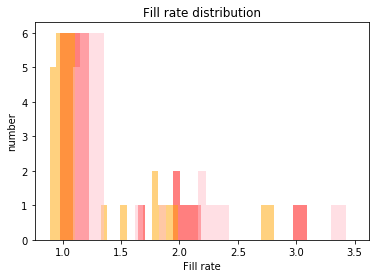

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
fillmean=fmean.tolist()
fillup=fup.tolist()
filllow=flow.tolist()
print(fillmean)
fp1=plt.hist(fillmean, bins=5, normed=0,facecolor='red', alpha=0.5,rwidth=0.5,label='a')  
fp2=plt.hist(fillup, bins=5, normed=0, facecolor='orange', alpha=0.5,rwidth=0.5,label='graph 2')
fp3=plt.hist(filllow, bins=5, normed=0, facecolor='pink', alpha=0.5,rwidth=0.5,label='graph 3')
plt.title('Fill rate distribution')
plt.xlabel('Fill rate')
plt.ylabel('number')
plt.show()
